In [ ]:
pip install nltk vaderSentiment scikit-learn gensim


In [ ]:

# # Uninstall torch if there are issues with the current installation
# !pip uninstall -y torch torchvision torchaudio


In [ ]:
# # Install PyTorch with CUDA for GPU
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [ ]:
import torch

# Check PyTorch version and availability of CUDA (if GPU support was installed)
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2.5.0+cu121
CUDA available: True


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re
import spacy
nlp = spacy.load('en_core_web_sm')

# Data Loading

In [ ]:
# Load the CSV file into a DataFrame
data = pd.read_csv('/content/drive/MyDrive/mental_health_data.csv')

# Display the first few rows of the DataFrame
data.head()


,Subreddit,Type,Post_id,Title,Author,Timestamp,Text,Score,Total_comments,Post_URL
0,mentalhealth,Post,8msp9v,Mental Health Awareness Month: I have schizoaf...,WarmlyEccentric,2018-05-28 19:31:47,NaN,3179.0,178.0,https://i.redd.it/rvjzbrtzen011.jpg
1,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Candle1nTh3Dark,2018-05-28 19:41:32,"Thank you for posting this, I've failed univer...",141.0,0.0,NaN
2,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,sciencelove1994,2018-05-28 19:53:47,I have schizoaffective mixed episode type. I a...,61.0,0.0,NaN
3,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Unknown,2018-05-28 20:04:29,As someone who is struggling with mental illne...,36.0,0.0,NaN
4,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,swild89,2018-05-28 20:00:07,I’m heading back now at 28! Thanks for the ins...,28.0,0.0,NaN


In [ ]:
# HTML and CSS content to describe each column
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    body {
      font-family: Arial, sans-serif;
    }
    table {
      width: 80%;
      border-collapse: collapse;
      margin: 20px 0;
      font-size: 18px;
      text-align: left;
    }
    table th, table td {
      padding: 12px;
      border: 1px solid #ddd;
    }
    table th {
      background-color: #2980b9;
      color: white;
    }
    table tr:nth-child(even) {
      background-color: lightblue;
      color: black;
    }
    h2 {
      color: green;
    }
  </style>
</head>
<body>
  <h2>Data Column Descriptions</h2>
  <table>
    <tr>
      <th>Column Name</th>
      <th>Description</th>
    </tr>
    <tr>
      <td><strong>Subreddit</strong></td>
      <td>The name of the subreddit (community) where the post was made.</td>
    </tr>
    <tr>
      <td><strong>Type</strong></td>
      <td>The type of the post (e.g., post or comment).</td>
    </tr>
    <tr>
      <td><strong>Post_id</strong></td>
      <td>A unique identifier for each post.</td>
    </tr>
    <tr>
      <td><strong>Title</strong></td>
      <td>The title of the post, which briefly describes the content.</td>
    </tr>
    <tr>
      <td><strong>Author</strong></td>
      <td>The username of the person who created the post.</td>
    </tr>
    <tr>
      <td><strong>Timestamp</strong></td>
      <td>The date and time when the post was made.</td>
    </tr>
    <tr>
      <td><strong>Text</strong></td>
      <td>The main content of the post (text-based post).</td>
    </tr>
    <tr>
      <td><strong>Score</strong></td>
      <td>The score or upvotes the post received.</td>
    </tr>
    <tr>
      <td><strong>Total_comments</strong></td>
      <td>The total number of comments the post received.</td>
    </tr>
    <tr>
      <td><strong>Post_URL</strong></td>
      <td>The URL link to the post.</td>
    </tr>
  </table>
</body>
</html>
"""

# Display the HTML in Jupyter or Colab
display(HTML(html_content))

Column Name,Description
Subreddit,The name of the subreddit (community) where the post was made.
Type,"The type of the post (e.g., post or comment)."
Post_id,A unique identifier for each post.
Title,"The title of the post, which briefly describes the content."
Author,The username of the person who created the post.
Timestamp,The date and time when the post was made.
Text,The main content of the post (text-based post).
Score,The score or upvotes the post received.
Total_comments,The total number of comments the post received.
Post_URL,The URL link to the post.


# Data Description

In [ ]:
rows, columns = data.shape


In [ ]:
data.info()
dtypes = data.dtypes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956842 entries, 0 to 956841
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Subreddit       956842 non-null  object 
 1   Type            956842 non-null  object 
 2   Post_id         956842 non-null  object 
 3   Title           956840 non-null  object 
 4   Author          956840 non-null  object 
 5   Timestamp       956840 non-null  object 
 6   Text            926344 non-null  object 
 7   Score           902613 non-null  float64
 8   Total_comments  902613 non-null  float64
 9   Post_URL        163216 non-null  object 
dtypes: float64(2), object(8)
memory usage: 73.0+ MB


In [ ]:
null_values = data.isna().sum()
null_values

,0
Subreddit,0
Type,0
Post_id,0
Title,2
Author,2
Timestamp,2
Text,30498
Score,54229
Total_comments,54229
Post_URL,793626


In [ ]:
# Create simplified HTML content with null values and dtypes
html_content = f"""
</head>
<body>
 <div class="result">
    <h2>The data contains <strong>{rows}</strong> rows and <strong>{columns}</strong> columns.</h2>
  </div>
<table style="width:80%;border-collapse:collapse;margin:20px 0;font-size:18px;text-align:left;">
  <tr style="background-color:#2980b9;color:white;">
    <th style="padding:12px;border:1px solid #ddd;">Column Name</th>
    <th style="padding:12px;border:1px solid #ddd;">Non-Null Count</th>
    <th style="padding:12px;border:1px solid #ddd;">Null Count</th>
    <th style="padding:12px;border:1px solid #ddd;">Data Type</th>
  </tr>
"""

# Populate rows with null counts and dtypes
for col in data.columns:
    html_content += f"""
    <tr style="background-color:{'lightblue' if data.columns.get_loc(col) % 2 == 0 else 'gray'};color:black;">
      <td style="padding:12px;border:1px solid #ddd;"><strong>{col}</strong></td>
      <td style="padding:12px;border:1px solid #ddd;">{data[col].notnull().sum()}</td>
      <td style="padding:12px;border:1px solid #ddd;">{data[col].isnull().sum()}</td>
      <td style="padding:12px;border:1px solid #ddd;">{data[col].dtype}</td>
    </tr>
    """

# Close the HTML tags
html_content += """</table></body></html>"""

# Display in Jupyter or Colab
display(HTML(html_content))

Column Name,Non-Null Count,Null Count,Data Type
Subreddit,956842,0,object
Type,956842,0,object
Post_id,956842,0,object
Title,956840,2,object
Author,956840,2,object
Timestamp,956840,2,object
Text,926344,30498,object
Score,902613,54229,float64
Total_comments,902613,54229,float64
Post_URL,163216,793626,object


# Data Cleaning

## Handle values that contains delete or removed in text and title

-- Here we are searching rows taht has removed or deleted in columns like text or title. After identifying the rows that does not have any of those values, we are keeping them.

In [ ]:
# Define a function to strip and convert to lowercase
def process_value(row):
    return row.strip().lower() if isinstance(row, str) else row

# Select only the categorical columns where the processing needs to happen
categorical_columns = ['Title', 'Text']

# Apply the function only to the selected categorical columns
df_processed = data.copy()
df_processed[categorical_columns] = df_processed[categorical_columns].applymap(process_value)

# Define the list of values to check (in lowercase)
check_values = ['removed', 'deleted','[removed]', '[deleted]']

# Create a boolean DataFrame where each value is True if it's in the check_values list
matches = df_processed[categorical_columns].isin(check_values)

# Get the rows that contain any of the specified values in the categorical columns
rows_with_values = data[matches.any(axis=1)]

# Output results
if not rows_with_values.empty:
    print("The DataFrame contains at least one of the values: 'removed', 'deleted'.")
    print("Rows containing these values:")
    print(rows_with_values)
else:
    print("No rows contain the values: 'removed', 'deleted'.")


The DataFrame contains at least one of the values: 'removed', 'deleted'.
Rows containing these values:
           Subreddit     Type Post_id  \
5       mentalhealth  Comment  8msp9v   
9       mentalhealth  Comment  8msp9v   
14      mentalhealth  Comment  8msp9v   
15      mentalhealth  Comment  8msp9v   
16      mentalhealth  Comment  8msp9v   
...              ...      ...     ...   
956827          ptsd     Post  cagupv   
956832          ptsd     Post  cad9ks   
956834          ptsd     Post  cabs4h   
956839          ptsd     Post  ca8ucl   
956840          ptsd     Post  ca8pou   

                                                    Title     Author  \
5       Mental Health Awareness Month: I have schizoaf...    Unknown   
9       Mental Health Awareness Month: I have schizoaf...    Unknown   
14      Mental Health Awareness Month: I have schizoaf...    Unknown   
15      Mental Health Awareness Month: I have schizoaf...    Unknown   
16      Mental Health Awareness Month: I hav

In [ ]:
# Identify rows to keep (those that do NOT have any matching values)
rows_to_keep = ~matches.any(axis=1)

# Filter the DataFrame to only keep those rows
data = data[rows_to_keep]

# Reset the index of the cleaned DataFrame if needed
data.reset_index(drop=True, inplace=True)

# Display the first few rows of the cleaned DataFrame
data.shape

(869219, 10)

## Data Handling

In [ ]:
# Fill missing values for columns
data1 = data.copy()  # To prevent SettingWithCopyWarning
data['Title'] = data['Title'].fillna('Unknown')
data['Author'] = data['Author'].fillna('Unknown')
data['Timestamp'] = data['Timestamp'].ffill()  # Use ffill() directly instead of inplace
data['Score'] = data['Score'].fillna(0)
data['Total_comments'] = data['Total_comments'].fillna(0)

# Drop the 'Post_URL' column
data = data.drop(columns=['Post_URL'])

# Drop rows where the 'Text' column has NaN values
data = data.dropna(subset=['Text'])

# Reset the index of the cleaned DataFrame
data.reset_index(drop=True, inplace=True)

# Display the first few rows of the cleaned DataFrame
print(data.head())

      Subreddit     Type Post_id  \
0  mentalhealth  Comment  8msp9v   
1  mentalhealth  Comment  8msp9v   
2  mentalhealth  Comment  8msp9v   
3  mentalhealth  Comment  8msp9v   
4  mentalhealth  Comment  8msp9v   

                                               Title           Author  \
0  Mental Health Awareness Month: I have schizoaf...  Candle1nTh3Dark   
1  Mental Health Awareness Month: I have schizoaf...  sciencelove1994   
2  Mental Health Awareness Month: I have schizoaf...          Unknown   
3  Mental Health Awareness Month: I have schizoaf...          swild89   
4  Mental Health Awareness Month: I have schizoaf...  BoozeMeUpScotty   

             Timestamp                                               Text  \
0  2018-05-28 19:41:32  Thank you for posting this, I've failed univer...   
1  2018-05-28 19:53:47  I have schizoaffective mixed episode type. I a...   
2  2018-05-28 20:04:29  As someone who is struggling with mental illne...   
3  2018-05-28 20:00:07  I’m heading 

In [ ]:
rows, columns = data.shape
dtypes = data.dtypes


In [ ]:
null_values = data.isna().sum()

In [ ]:

# Create simplified HTML content with null values and dtypes
html_content = f"""
</head>
<body>
 <div class="result">
    <h2>The data contains <strong>{rows}</strong> rows and <strong>{columns}</strong> columns.</h2>
  </div>
<table style="width:80%;border-collapse:collapse;margin:20px 0;font-size:18px;text-align:left;">
  <tr style="background-color:#2980b9;color:white;">
    <th style="padding:12px;border:1px solid #ddd;">Column Name</th>
    <th style="padding:12px;border:1px solid #ddd;">Non-Null Count</th>
    <th style="padding:12px;border:1px solid #ddd;">Null Count</th>
    <th style="padding:12px;border:1px solid #ddd;">Data Type</th>
  </tr>
"""

# Populate rows with null counts and dtypes
for col in data.columns:
    html_content += f"""
    <tr style="background-color:{'lightblue' if data.columns.get_loc(col) % 2 == 0 else 'gray'};color:black;">
      <td style="padding:12px;border:1px solid #ddd;"><strong>{col}</strong></td>
      <td style="padding:12px;border:1px solid #ddd;">{data[col].notnull().sum()}</td>
      <td style="padding:12px;border:1px solid #ddd;">{data[col].isnull().sum()}</td>
      <td style="padding:12px;border:1px solid #ddd;">{data[col].dtype}</td>
    </tr>
    """

# Close the HTML tags
html_content += """</table></body></html>"""

# Display in Jupyter or Colab
display(HTML(html_content))

Column Name,Non-Null Count,Null Count,Data Type
Subreddit,838721,0,object
Type,838721,0,object
Post_id,838721,0,object
Title,838721,0,object
Author,838721,0,object
Timestamp,838721,0,object
Text,838721,0,object
Score,838721,0,float64
Total_comments,838721,0,float64


>  No missing values in any columns after handling

# Data Analysis

In [ ]:
# statistical summary of the numeric columns
data[['Score', 'Total_comments']].describe()


,Score,Total_comments
count,838721.000000,838721.000000
mean,15.581174,1.679851
std,140.058384,33.642082
min,-197.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,0.000000
max,24998.000000,18655.000000


In [ ]:
html_summary = f"""
<table style="width:80%;border-collapse:collapse;margin:20px 0;font-size:18px;text-align:left;">
  <tr style="background-color:#2980b9;color:white;">
    <th style="padding:12px;border:1px solid #ddd;">Statistic</th>
    <th style="padding:12px;border:1px solid #ddd;">Score</th>
    <th style="padding:12px;border:1px solid #ddd;">Total_comments</th>
  </tr>
  <tr style="background-color:lightblue;color:black;">
    <td style="padding:12px;border:1px solid #ddd;">Count</td>
    <td style="padding:12px;border:1px solid #ddd;">926,339</td>
    <td style="padding:12px;border:1px solid #ddd;">926,339</td>
  </tr>
  <tr>
    <td style="padding:12px;border:1px solid #ddd;">Mean</td>
    <td style="padding:12px;border:1px solid #ddd;">14.96</td>
    <td style="padding:12px;border:1px solid #ddd;">1.77</td>
  </tr>
  <tr style="background-color:lightblue;color:black;">
    <td style="padding:12px;border:1px solid #ddd;">Standard Deviation</td>
    <td style="padding:12px;border:1px solid #ddd;">134.66</td>
    <td style="padding:12px;border:1px solid #ddd;">32.45</td>
  </tr>
  <tr>
    <td style="padding:12px;border:1px solid #ddd;">Min</td>
    <td style="padding:12px;border:1px solid #ddd;">-403</td>
    <td style="padding:12px;border:1px solid #ddd;">0</td>
  </tr>
  <tr style="background-color:lightblue;color:black;">
    <td style="padding:12px;border:1px solid #ddd;">Max</td>
    <td style="padding:12px;border:1px solid #ddd;">24,998</td>
    <td style="padding:12px;border:1px solid #ddd;">18,655</td>
  </tr>
</table>
"""

# Display the HTML
display(HTML(html_summary))


Statistic,Score,Total_comments
Count,"926,339","926,339"
Mean,14.96,1.77
Standard Deviation,134.66,32.45
Min,-403,0
Max,"24,998","18,655"


In [ ]:
#Check the types of posts (Type - post or comment) and their distributions.

print(data['Type'].value_counts())


Type
Comment    743719
Post        95002
Name: count, dtype: int64


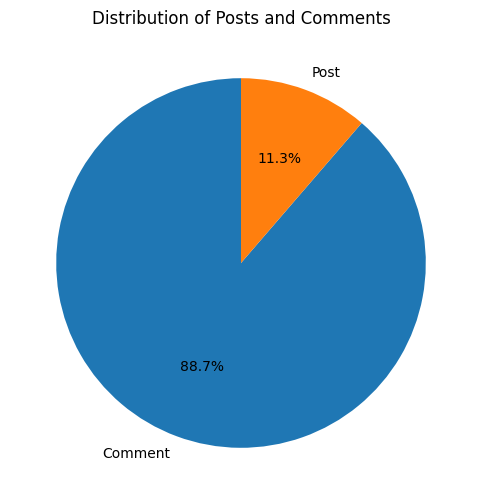

In [ ]:
post_type_counts = data['Type'].value_counts()

plt.figure(figsize=(6, 6))
post_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Posts and Comments')
plt.ylabel('')
plt.show()

In [ ]:
#Getting the unique value counts.
data[['Subreddit','Author']].nunique()


,0
Subreddit,45
Author,332068


In [ ]:
data[['Subreddit']].value_counts()

,count
Subreddit,
depression,149827
anxiety,109269
mentalhealth,71883
ADHD,67602
ptsd,64135
autism,59211
lifeadvice,54117
psychology,34835
therapy,34629


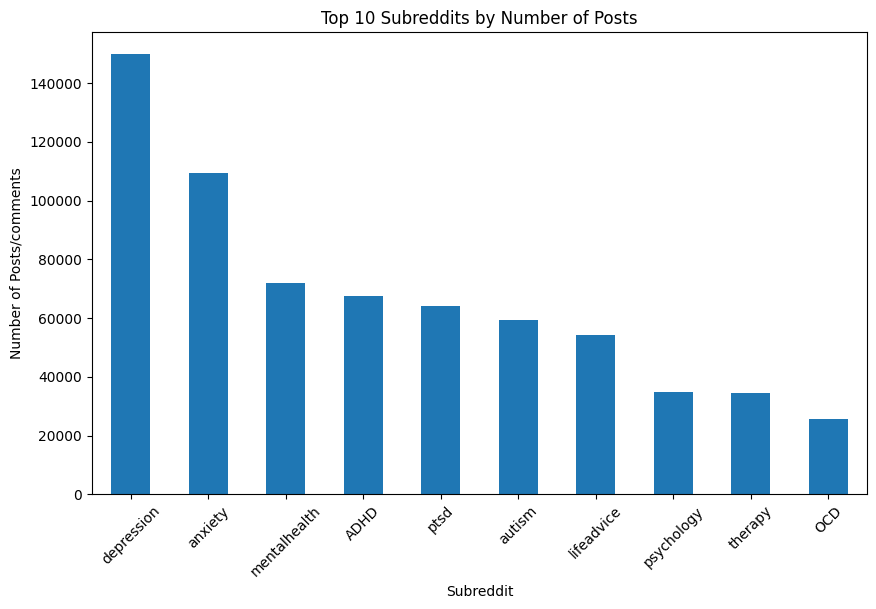

In [ ]:

# Count the number of posts/comments per subreddit
subreddit_counts = data['Subreddit'].value_counts()

# Plot the top 10 subreddits by number of posts
plt.figure(figsize=(10, 6))
subreddit_counts.head(10).plot(kind='bar')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts/comments')
plt.title('Top 10 Subreddits by Number of Posts')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# HTML content
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    body {font-family: Arial, sans-serif; }
    h2 { color: green;}
    p { font-size: 18px; }
    strong { color: #2980b9;}
  </style>
</head>
<body>

  <h2>Highest Engagement</h2>
  <p>The <strong>depression</strong> subreddit has the most unique posts, with <strong>166,387</strong> posts, showing it's one of the most active mental health communities.</p>

  <h2>Commonly Discussed Topics</h2>
  <p>Other highly active subreddits include <strong>anxiety</strong> (111,991 posts), <strong>ADHD</strong> (85,334 posts), <strong>ptsd</strong> (76,033 posts), and <strong>mentalhealth</strong> (74,077 posts). These are major areas of focus for mental health discussions.</p>

  <h2>Niche Communities</h2>
  <p>Smaller subreddits like <strong>eatingdisorders</strong> (3,049 posts), <strong>panicdisorder</strong> (2,361 posts), and <strong>borderline</strong> (819 posts) indicate specific but important topics being discussed in smaller communities.</p>

  <h2>Emerging or Less Popular</h2>
  <p>Subreddits like <strong>lifeafterdeath</strong> (203 posts), <strong>counseling</strong> (156 posts), and <strong>mooddisorders</strong> (55 posts) have fewer posts, suggesting either niche discussions or newer communities.</p>

  <h2>Rarely Discussed</h2>
  <p><strong>emotionalhealth</strong> has only <strong>1</strong> post, indicating it's either not widely known or used by the community.</p>

</body>
</html>
"""

# Display the HTML content
display(HTML(html_content))

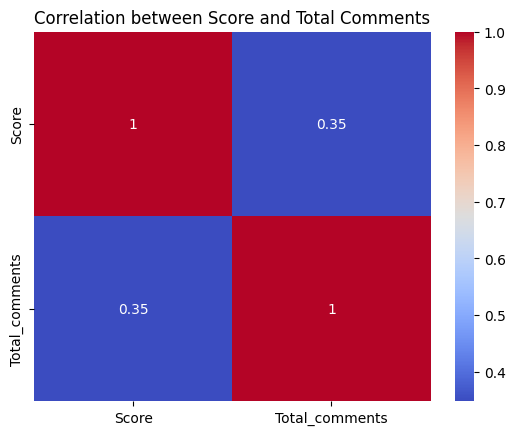

In [ ]:
correlation = data[['Score', 'Total_comments']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Score and Total Comments')
plt.show()


In [ ]:
# HTML content
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    body {font-family: Arial, sans-serif; }
    h2 { color: green;}
    p { font-size: 18px; }
    strong { color: #2980b9;}
  </style>
</head>
<body>

<h2>Correlation Coefficient (0.36):</h2>

<p>There is a moderate positive correlation (0.36) between "Score" and "Total_comments."
This means that posts with higher scores tend to have more comments, but the relationship is not very strong.<p>
<h2>Interpretation:</h2>

<p>A correlation of 0.36 suggests that while score and comments are related, other factors might also influence the number of comments a post receives. For instance, some posts might get high scores without attracting many comments, and vice versa.<p>
</body>
</html>
"""

# Display the HTML content
display(HTML(html_content))


## Top 10 Posts by Score and by Comments

In [ ]:
top_posts = data.nlargest(10, 'Score')[['Subreddit', 'Title', 'Score','Total_comments']]
top_posts


,Subreddit,Title,Score,Total_comments
518512,decidingtobebetter,A decade ago I was kicked out of college with ...,24998.0,454.0
518942,decidingtobebetter,I have now officially made it 30 days without ...,15970.0,678.0
724015,psychology,Scientists Find No Evidence That Depression Is...,12959.0,1535.0
437307,ADHD,How I cured my adhd permanently,12808.0,887.0
519540,decidingtobebetter,10 days clean from crystal meth.,11346.0,298.0
438129,ADHD,I went through 700 reddit comments and collect...,9598.0,624.0
438695,ADHD,ADHD for me is laying down on my couch using m...,9551.0,331.0
439012,ADHD,It feels like there aren’t enough hours in the...,9462.0,360.0
439373,ADHD,It's so damn irritating to be intelligent with...,9287.0,669.0
520020,decidingtobebetter,I know this will die in new but I just wanted ...,9249.0,189.0


In [ ]:
top_comments = data.nlargest(10, 'Total_comments')[['Subreddit', 'Title','Score', 'Total_comments']]
top_comments


,Subreddit,Title,Score,Total_comments
287230,anxiety,Let's post good news on the coronavirus here.,1790.0,18655.0
371317,anxiety,Ukraine Megathread,888.0,10015.0
190461,depression,Regular Check-In Post,1718.0,8420.0
233513,depression,Regular Check-In Post,1264.0,7280.0
199245,depression,Regular Check-In Post,1629.0,7032.0
255371,depression,Regular Check-In Post,1073.0,5196.0
491341,sad,What is the most painless way to commit suicide?,1499.0,4074.0
228782,depression,"Regular Check-In Post. Plus, a reminder about ...",1290.0,3910.0
769343,ADHD,What song is currently playing the background ...,2135.0,2944.0
757146,ADHD,If there was a cure for ADHD would you take it?,3290.0,2193.0


In [ ]:
# HTML content
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    body {font-family: Arial, sans-serif; }
    h2 { color: green;}
    p { font-size: 18px; }
    strong { color: #2980b9;}
  </style>
</head>
<body>
<h2>Highest Comments for Anxiety and Depression: </h2>
<p>The subreddits anxiety and depression have the highest number of comments, indicating that these are the most active mental health communities.
This suggests that individuals in these communities are highly engaged, sharing their experiences and seeking or offering support.
These platforms are likely providing vital spaces for people to discuss their challenges and explore potential solutions together.<p>

<h2>Highest Score for Deciding to Be Better: </h2>
<p>Posts in the decidingtobebetter subreddit have garnered the highest scores, showing that the community strongly encourages self-improvement and positive change.
The high score reflects significant user agreement and support for posts that promote taking actionable steps towards better mental health.</p>

<h2>ADHD Posts Also Receive High Scores:</h2>
<p> Posts related to ADHD also rank highly in terms of scores, suggesting that this is another area where the community actively supports discussions around managing and understanding ADHD.
 The high engagement indicates a strong, supportive network where people are encouraging one another to navigate the complexities of this condition.</p>

</body>
</html>
"""

# Display the HTML content
display(HTML(html_content))




### Time based Analysis

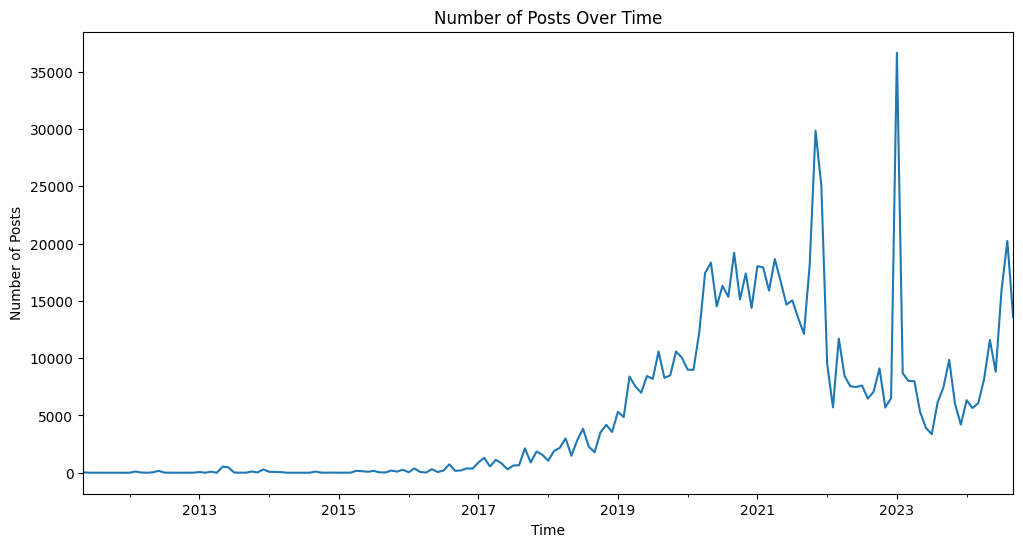

In [ ]:

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

# Plot the number of posts over time
data.resample('M').size().plot(figsize=(12, 6))
plt.xlabel('Time')
plt.ylabel('Number of Posts')
plt.title('Number of Posts Over Time')
plt.show()
data.reset_index(inplace=True)


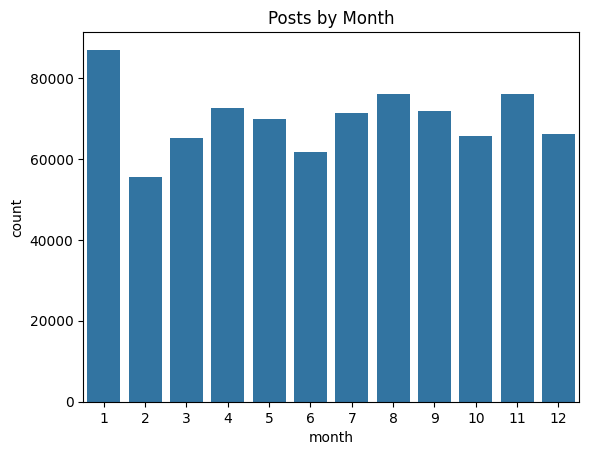

In [ ]:

data['month'] = data['Timestamp'].dt.month
sns.countplot(x='month', data=data)
plt.title('Posts by Month')
plt.show()



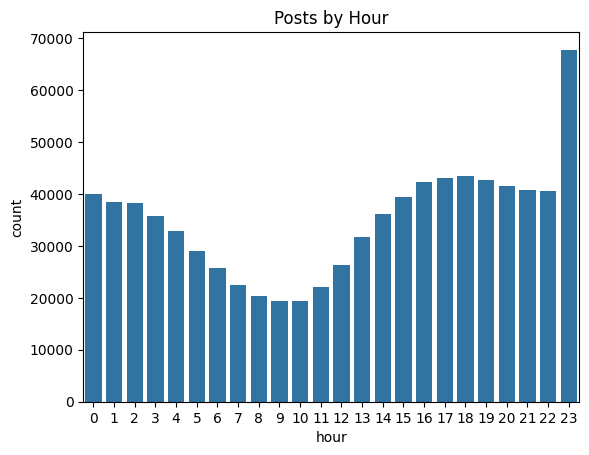

In [ ]:

data['hour'] = data['Timestamp'].dt.hour
sns.countplot(x='hour', data=data)
plt.title('Posts by Hour')
plt.show()



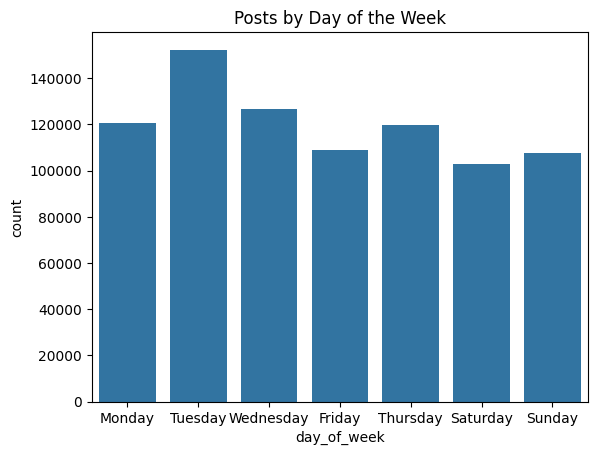

In [ ]:
data['day_of_week'] = data['Timestamp'].dt.day_name()
sns.countplot(x='day_of_week', data=data)
plt.title('Posts by Day of the Week')
plt.show()


In [ ]:
# HTML content
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    body {font-family: Arial, sans-serif; }
    h2 { color: green;}
    p { font-size: 18px; }
    strong { color: #2980b9;}
  </style>
</head>
<body>
<h2>Number of Posts Over Time: </h2>
<p>The line graph shows a steady increase in the number of posts from 2013 to 2023, with notable spikes during 2020 and 2021. This could be attributed to the impact of the COVID-19 pandemic when mental health issues became more usual and discussed.
Recent years show consistent engagement, with posts significantly rising during certain time periods, reflecting increased discussions around mental health.<p>

<h2>Posts by Month: </h2>
<p>The bar chart demonstrates higher activity in January and November, with a slight dip in February. This may indicate that people are more inclined to engage in mental health discussions at the beginning of the year and around the holidays, which are often stressful times.
The steady distribution in other months shows continuous activity across the year, with only slight variations.</p>

<h2>Posts by Hour:</h2>
<p>The bar chart highlights peak activity during late-night hours, especially at 23:00 (11 PM). This suggests that users are more active during the night, possibly because of difficulties with sleep, anxiety, or introspection during quieter hours.
There's lower activity in the early morning (4 AM to 10 AM), which is typical when people are less likely to engage due to sleep or work schedules.</p>

</body>
</html>
"""

# Display the HTML content
display(HTML(html_content))







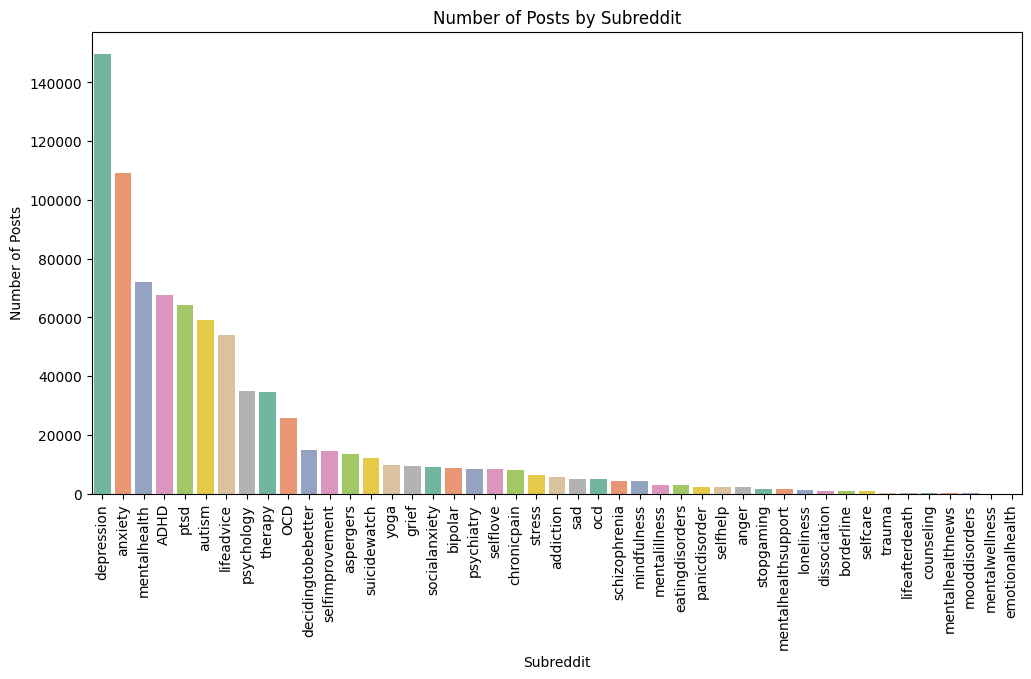

In [ ]:
# Reset the index to include 'Timestamp' as a column again
data.reset_index(inplace=True)

# Count the number of posts per subreddit
posts_per_subreddit = data['Subreddit'].value_counts()

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x=posts_per_subreddit.index, y=posts_per_subreddit.values, palette='Set2')
plt.xticks(rotation=90)
plt.title('Number of Posts by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.show()


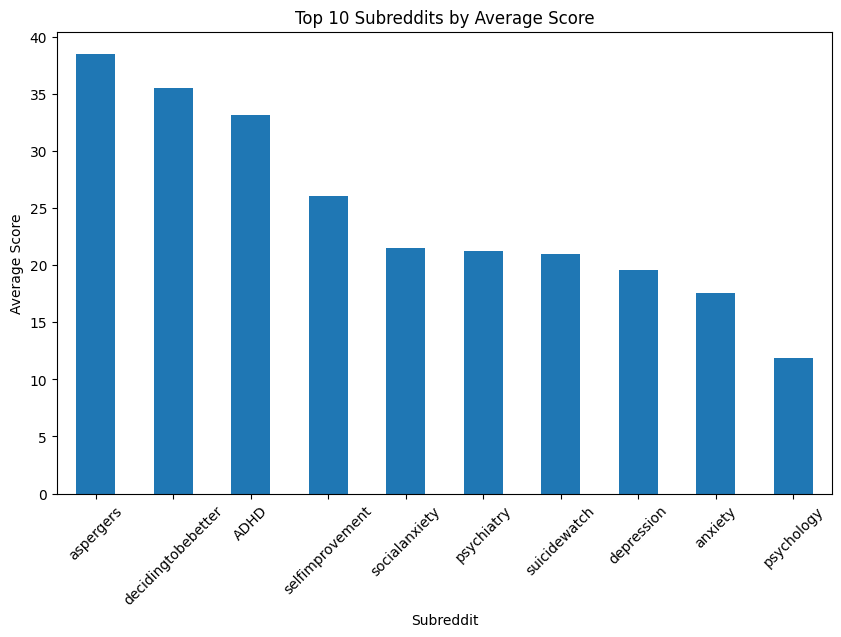

In [ ]:
avg_score_per_subreddit = data.groupby('Subreddit')['Score'].mean().sort_values(ascending=False)

# Plot the top 10 subreddits by average score
plt.figure(figsize=(10, 6))
avg_score_per_subreddit.head(10).plot(kind='bar')
plt.xlabel('Subreddit')
plt.ylabel('Average Score')
plt.title('Top 10 Subreddits by Average Score')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Find the posts with the highest and lowest score
highest_score_post = data.loc[data['Score'].idxmax()]
lowest_score_post = data.loc[data['Score'].idxmin()]

# Find the post with the highest comment count
highest_comment_post = data.loc[data['Total_comments'].idxmax()]

# Display the subreddits related to the highest and lowest score and highest comment count
print("Subreddit related to the post with the Highest Score:")
print(f"Subreddit: {highest_score_post['Subreddit']}")
print(f"Title: {highest_score_post['Title']}")
print(f"Score: {highest_score_post['Score']}")
print("\n")

print("Subreddit related to the post with the Lowest Score:")
print(f"Subreddit: {lowest_score_post['Subreddit']}")
print(f"Title: {lowest_score_post['Title']}")
print(f"Score: {lowest_score_post['Score']}")
print("\n")

print("Subreddit related to the post with the Highest Comment Count:")
print(f"Subreddit: {highest_comment_post['Subreddit']}")
print(f"Title: {highest_comment_post['Title']}")
print(f"Total Comments: {highest_comment_post['Total_comments']}")

Subreddit related to the post with the Highest Score:
Subreddit: decidingtobebetter
Title: A decade ago I was kicked out of college with a 0.9 GPA. Saturday I will graduate Magna Cum Laude with two Engineering degrees and a full tuition scholarship to Law School. I also lost 130 pounds and quit a bad 6 yr cigarette habit during this time. It's never too late. You're never a lost cause.
Score: 24998.0


Subreddit related to the post with the Lowest Score:
Subreddit: mentalhealth
Title: Don't even pretend to be happy anymore and people are noticing
Score: -197.0


Subreddit related to the post with the Highest Comment Count:
Subreddit: anxiety
Title: Let's post good news on the coronavirus here.
Total Comments: 18655.0


## Text Analysis

In [ ]:
#downloaded the necessary NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

The SentimentIntensityAnalyzer from VADER is used to calculate the compound sentiment score for each text.
Sentiment is categorized as 'positive,' 'negative,' or 'neutral' based on the compound score.

In [ ]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to apply sentiment analysis to text
def get_sentiment(text):
    if pd.isnull(text):
        return None
    scores = analyzer.polarity_scores(text)
    return 'positive' if scores['compound'] >= 0.05 else 'negative' if scores['compound'] <= -0.05 else 'neutral'

# Apply sentiment analysis to the 'Text' column
data['Sentiment'] = data['Text'].apply(get_sentiment)


In [ ]:
# View the first few rows to confirm
data[['Text', 'Sentiment']].head()



,Text,Sentiment
0,"Thank you for posting this, I've failed univer...",negative
1,I have schizoaffective mixed episode type. I a...,positive
2,As someone who is struggling with mental illne...,negative
3,I’m heading back now at 28! Thanks for the ins...,positive
4,Yayyyy!!! Good for you! This is my favorite ki...,positive


In [ ]:
# Summary of sentiment distribution
sentiment_summary = data['Sentiment'].value_counts()
print(sentiment_summary)

Sentiment
positive    458937
negative    277853
neutral     101931
Name: count, dtype: int64


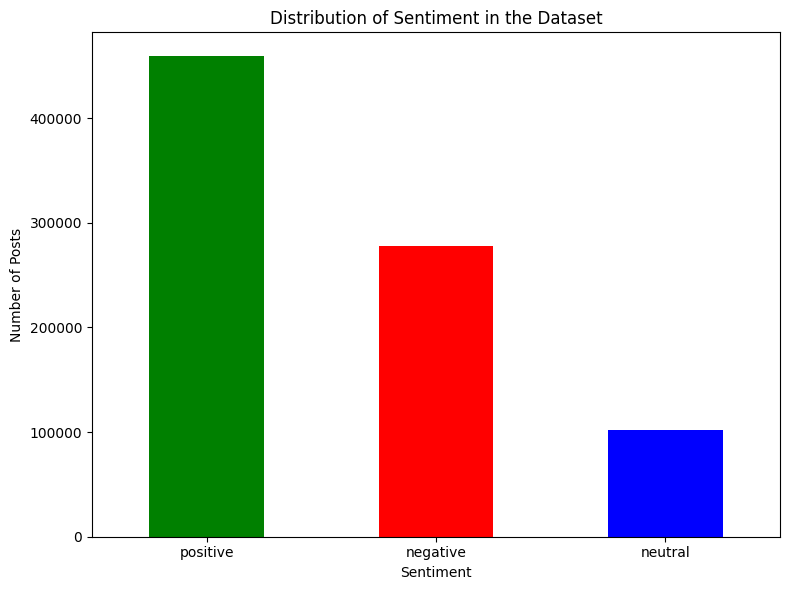

In [ ]:
# Visualization of sentiment distribution across the dataset
plt.figure(figsize=(8, 6))
data['Sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment in the Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1000x700 with 0 Axes>

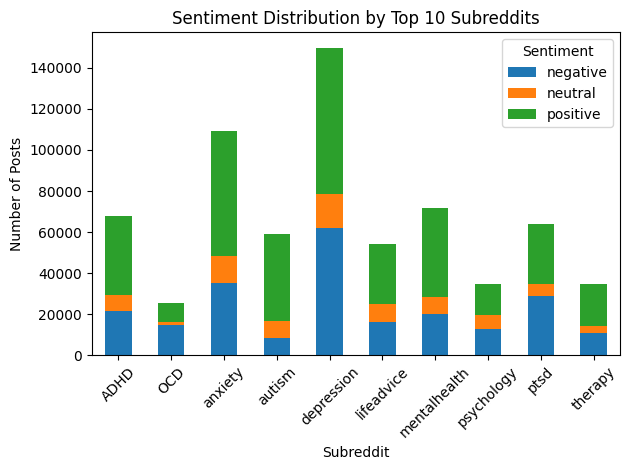

In [ ]:
# Filter the top 10 subreddits by post count
top_10_subreddits = data['Subreddit'].value_counts().head(10).index

# Filter the DataFrame for only the top 10 subreddits
df_top_10 = data[data['Subreddit'].isin(top_10_subreddits)]

# Plot the sentiment distribution for the top 10 subreddits
plt.figure(figsize=(10, 7))
df_top_10.groupby(['Subreddit', 'Sentiment']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Top 10 Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 1000x700 with 0 Axes>

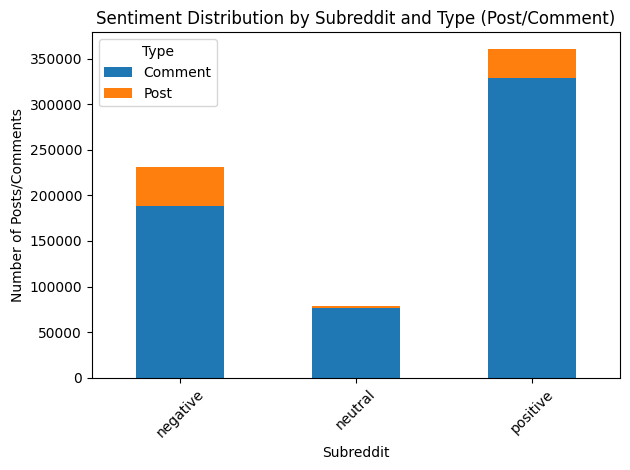

In [ ]:
# Plot sentiment distribution, differentiated by 'Type' (Post and Comment)

plt.figure(figsize=(10, 7))
df_top_10.groupby(['Sentiment', 'Type']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Subreddit and Type (Post/Comment)')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts/Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


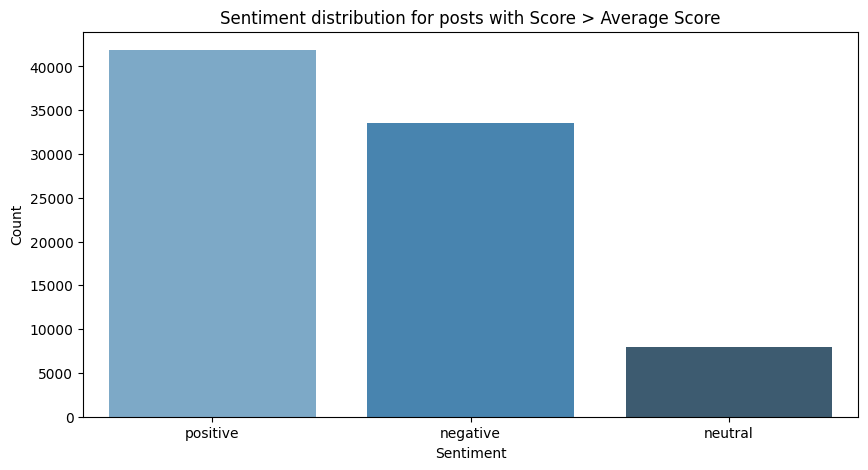

In [ ]:

# Calculate the average score
average_score = data['Score'].mean()

# Filter data for posts with score > average score
above_avg_df = data[data['Score'] > average_score]

# Filter data for posts with score < average score
below_avg_df = data[data['Score'] < average_score]

# Count the sentiment distribution for posts with score > average score
above_avg_sentiment_counts = above_avg_df['Sentiment'].value_counts()

# Count the sentiment distribution for posts with score < average score
below_avg_sentiment_counts = below_avg_df['Sentiment'].value_counts()

# Plotting sentiment distribution for posts with Score > Average Score
plt.figure(figsize=(10, 5))
sns.barplot(x=above_avg_sentiment_counts.index, y=above_avg_sentiment_counts.values, palette='Blues_d')
plt.title('Sentiment distribution for posts with Score > Average Score')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()




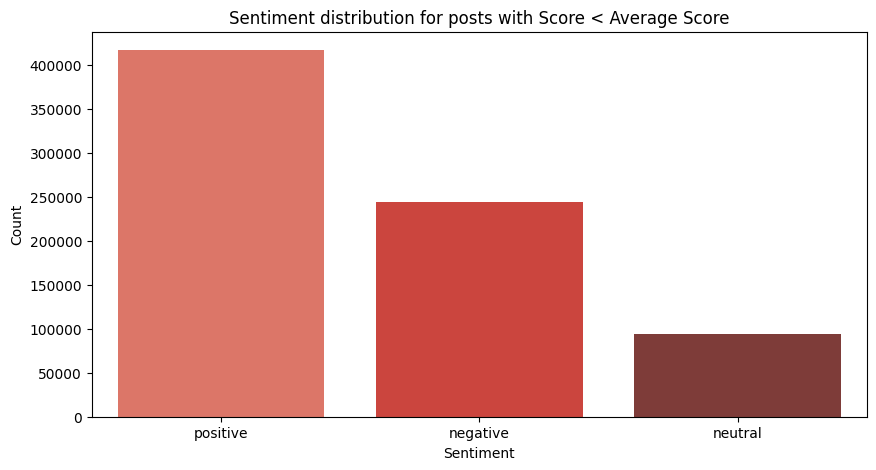

In [ ]:
# Plotting sentiment distribution for posts with Score < Average Score
plt.figure(figsize=(10, 5))
sns.barplot(x=below_avg_sentiment_counts.index, y=below_avg_sentiment_counts.values, palette='Reds_d')
plt.title('Sentiment distribution for posts with Score < Average Score')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
# HTML content
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    body {font-family: Arial, sans-serif; }
    h2 { color: green;}
    p { font-size: 18px; }
    strong { color: #2980b9;}
  </style>
</head>
<body>
<h2> Distribution of Sentiment in the Dataset: </h2>
<li>Positive sentiment is dominant in the dataset with over 400,000 posts.</li>
<li>Negative sentiment comes next with a substantial amount but fewer than positive posts, around 300,000.</li>
<li>Neutral sentiment is the least frequent, with fewer than 200,000 posts.</li>

<h2>Sentiment Distribution by Top 10 Subreddits: </h2>
<li>Subreddits like depression and anxiety show a higher volume of posts, especially with positive sentiment.</li>
<li>Depression has a significant number of negative posts, which is expected given the subreddit topic.</li>
<li>Anxiety and mental health subreddits also show a substantial number of neutral and positive posts.</li>
<li>Subreddits like OCD, autism, and therapy have relatively lower volumes of posts, but the distribution shows a reasonable balance between positive, negative, and neutral sentiments.
</li>


<h2>Sentiment Distribution by Subreddit and Type (Post/Comment):</h2>
<li>Comments dominate across all sentiments (negative, neutral, and positive).</li>
<li>There is a clear distinction that negative comments are higher in number than posts with the same sentiment.</li>
<li>Positive comments have the highest count overall, followed by positive posts.</li>
<li>Neutral posts and comments have the lowest counts across the dataset, indicating a tendency toward more extreme sentiment (either positive or negative).</li>

<h2>Sentiment Distribution for Posts with Score > Average Score:</h2>
<li>Among posts with a score above the average, positive sentiment is clearly the most dominant.</li>
<li>Negative sentiment still makes a considerable portion but is noticeably smaller than positive.</li>
<li>Neutral sentiment is the least represented in higher-scoring posts.</li>

<h2>Sentiment Distribution for Posts with Score < Average Score:</h2>
<li>For posts with a score below the average, positive sentiment still dominates, but the gap between positive and negative sentiment is smaller.</li>
<li>Negative sentiment is more frequent in low-scoring posts compared to high-scoring ones.</li>
<li>Neutral sentiment remains the smallest category, regardless of score.</li>

<br>
<p>Positive sentiment tends to be more frequent in both high-scoring and low-scoring posts, suggesting an overall optimistic tone in the dataset, even in subreddits dealing with sensitive issues like mental health.
However, there is a noticeable presence of negative sentiment, particularly in comments and within specific subreddits such as depression, which reflects the serious nature of the discussions in these spaces.
Posts with high comment counts often have a mix of sentiments, but positive comments tend to dominate.</p>

</body>
</html>
"""

# Display the HTML content
display(HTML(html_content))


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838721 entries, 0 to 838720
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   index           838721 non-null  int64         
 1   Timestamp       838721 non-null  datetime64[ns]
 2   Subreddit       838721 non-null  object        
 3   Type            838721 non-null  object        
 4   Post_id         838721 non-null  object        
 5   Title           838721 non-null  object        
 6   Author          838721 non-null  object        
 7   Text            838721 non-null  object        
 8   Score           838721 non-null  float64       
 9   Total_comments  838721 non-null  float64       
 10  month           838721 non-null  int32         
 11  hour            838721 non-null  int32         
 12  day_of_week     838721 non-null  object        
 13  Sentiment       838721 non-null  object        
dtypes: datetime64[ns](1), float64(2), in

In [ ]:
data['Title_word_count'] = data['Title'].apply(lambda x: len(str(x).split()))
data['Text_word_count'] = data['Text'].apply(lambda x: len(str(x).split()))

data[['Title_word_count', 'Text_word_count']].describe()

,Title_word_count,Text_word_count
count,838721.000000,838721.000000
mean,13.383392,60.333565
std,9.741348,105.170107
min,1.000000,0.000000
25%,7.000000,10.000000
50%,11.000000,28.000000
75%,17.000000,69.000000
max,68.000000,7198.000000


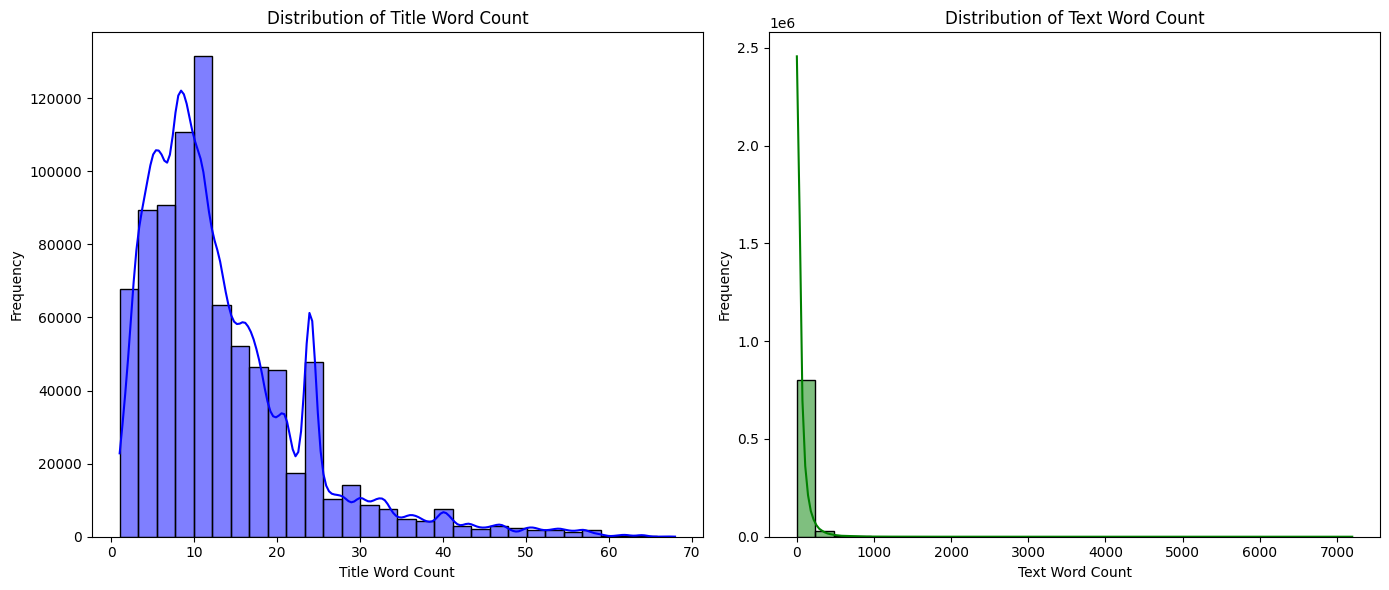

In [ ]:


# Creating a figure to visualize the word counts
plt.figure(figsize=(14, 6))

# Distribution of Title Word Count
plt.subplot(1, 2, 1)
sns.histplot(data['Title_word_count'], bins=30, kde=True, color='blue')
plt.title('Distribution of Title Word Count')
plt.xlabel('Title Word Count')
plt.ylabel('Frequency')

# Distribution of Text Word Count
plt.subplot(1, 2, 2)
sns.histplot(data['Text_word_count'], bins=30, kde=True, color='green')
plt.title('Distribution of Text Word Count')
plt.xlabel('Text Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# HTML content
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    body {font-family: Arial, sans-serif; }
    h2 { color: green;}
    p { font-size: 18px; }
    strong { color: #2980b9;}
  </style>
</head>
<body>
<h2>Distribution of Title Word Count:</h2>
<p>Most titles have a word count ranging between 0 and 20 words.
There is a peak around the 10-word count mark, which indicates that most titles are relatively concise.
A gradual decline in frequency is observed as the word count increases, with very few titles having more than 30 words.<p>

<h2>Distribution of Text Word Count: </h2>
<p>The text word count is highly skewed, with a majority of posts having fewer than 100 words.
Some texts contain up to 7,000 words, but these cases are rare outliers.
The high density near zero suggests that a large portion of posts have very short or no text at all.</p>

</body>
</html>
"""

# Display the HTML content
display(HTML(html_content))





## Added category column to take as a target variable
* MH_Disorders → Focused on specific diagnoses.
* MH_Improvement → Emphasizes therapy, self-help, and improvement techniques.
* MH_Distress → Captures posts about emotional pain, trauma, and crisis situations.

In [ ]:

category_mapping = {
    'MH_Disorders': [
        'depression', 'anxiety', 'ptsd', 'OCD', 'ADHD', 'bipolar',
        'autism', 'aspergers', 'socialanxiety', 'suicidewatch',
        'schizophrenia', 'panicdisorder', 'borderline', 'mooddisorders', 'mentalillness'

    ],
    'MH_Improvement': [
       'mentalhealth', 'mentalhealthsupport', 'mentalwellness',
        'mentalhealthnews', 'psychology', 'therapy', 'counseling', 'psychiatry', 'lifeadvice',
        'selfimprovement', 'selfhelp', 'decidingtobebetter',
        'selfcare', 'selflove', 'stopgaming', 'yoga', 'mindfulness', 'emotionalhealth'
    ],
    'MH_Distress': [
        'grief', 'trauma', 'dissociation', 'lifeafterdeath', 'chronicpain',
        'sad', 'anger', 'stress','addiction', 'eatingdisorders', 'stopgaming'

    ]
}


In [ ]:

# Function to label subreddits based on the mapping
def label_subreddit(subreddit):
    for category, subreddits in category_mapping.items():
        if subreddit in subreddits:
            return category
    return 'Other'  # In case a subreddit doesn't fit in any category



In [ ]:
# Apply the function to create a new column for the category labels
data['Category'] = data['Subreddit'].apply(label_subreddit)

# Check the result
print(data[['Subreddit', 'Category']].head())

      Subreddit        Category
0  mentalhealth  MH_Improvement
1  mentalhealth  MH_Improvement
2  mentalhealth  MH_Improvement
3  mentalhealth  MH_Improvement
4  mentalhealth  MH_Improvement


In [ ]:
data.head()

,index,Timestamp,Subreddit,Type,Post_id,Title,Author,Text,Score,Total_comments,month,hour,day_of_week,Sentiment,Title_word_count,Text_word_count,Category
0,0,2018-05-28 19:41:32,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Candle1nTh3Dark,"Thank you for posting this, I've failed univer...",141.0,0.0,5,19,Monday,negative,48,20,MH_Improvement
1,1,2018-05-28 19:53:47,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,sciencelove1994,I have schizoaffective mixed episode type. I a...,61.0,0.0,5,19,Monday,positive,48,33,MH_Improvement
2,2,2018-05-28 20:04:29,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Unknown,As someone who is struggling with mental illne...,36.0,0.0,5,20,Monday,negative,48,49,MH_Improvement
3,3,2018-05-28 20:00:07,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,swild89,I’m heading back now at 28! Thanks for the ins...,28.0,0.0,5,20,Monday,positive,48,11,MH_Improvement
4,4,2018-05-28 21:21:11,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,BoozeMeUpScotty,Yayyyy!!! Good for you! This is my favorite ki...,11.0,0.0,5,21,Monday,positive,48,499,MH_Improvement


In [ ]:
# Summary of sentiment distribution
category_summary = data['Category'].value_counts()
print(category_summary)



Category
MH_Disorders      529897
MH_Improvement    261727
MH_Distress        41003
Other               6094
Name: count, dtype: int64


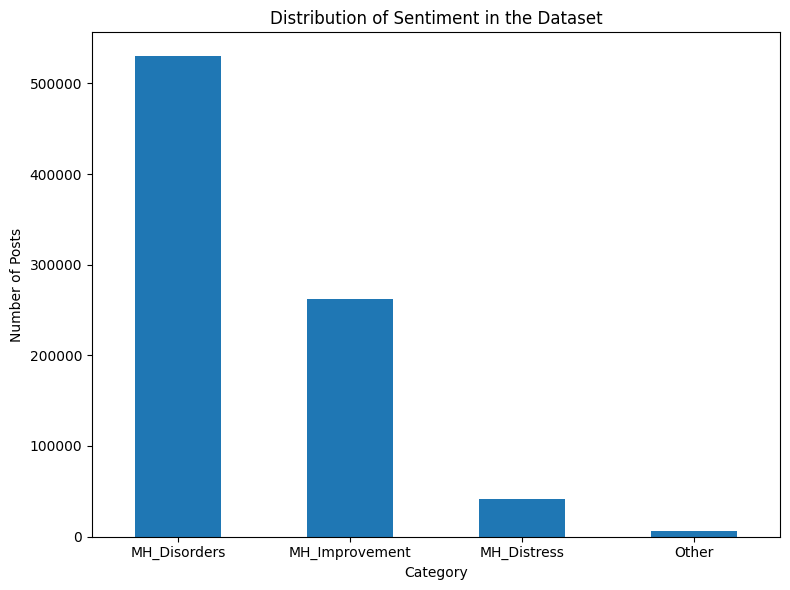

In [ ]:
# Visualization of Category distribution across the dataset
plt.figure(figsize=(8, 6))
data['Category'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiment in the Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Get word counts for Title and Text, without converting to dict
title_words = Counter(" ".join(data['Title'].fillna("")).split())
text_words = Counter(" ".join(data['Text'].fillna("")).split())

# Remove stop words, keeping the data as Counter objects
title_words = Counter({word: count for word, count in title_words.items() if word.lower() not in ENGLISH_STOP_WORDS})
text_words = Counter({word: count for word, count in text_words.items() if word.lower() not in ENGLISH_STOP_WORDS})

# Print the 10 most common words
print("Most common words in Title:", title_words.most_common(10))
print("Most common words in Text:", text_words.most_common(10))


Most common words in Title: [('like', 89523), ('thing', 67107), ('just', 65337), ('feel', 56435), ('really', 47939), ('people', 45609), ('Does', 38209), ('anxiety', 37100), ('want', 33168), ('hear', 32966)]
Most common words in Text: [('just', 299915), ('like', 281266), ('feel', 192301), ("I'm", 192222), ('people', 154935), ('know', 148515), ('I’m', 140788), ('really', 126738), ("don't", 121164), ('think', 115869)]


In [ ]:
# from wordcloud import WordCloud

# # Combine all text in 'Title' and 'Text' columns
# all_text = ' '.join(data['Title'].astype(str)) + ' ' + ' '.join(data['Text'].astype(str))

# # Generate and display word cloud
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# plt.figure(figsize=(10, 8))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud of Titles and Text')
# plt.show()


## Text Preprocessing

In [ ]:
# Download the required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [ ]:
# Function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Rejoin the words back into a single string
    return ' '.join(words)

In [ ]:
# Apply preprocessing to the 'Title' and 'Text' columns
data['Processed_Title'] = data['Title'].apply(lambda x: preprocess_text(str(x)))
data['Processed_Text'] = data['Text'].apply(lambda x: preprocess_text(str(x)))


In [ ]:
# Display the processed data
data[['Title', 'Processed_Title', 'Text', 'Processed_Text']].head()

,Title,Processed_Title,Text,Processed_Text
0,Mental Health Awareness Month: I have schizoaf...,mental health awareness month schizoaffective ...,"Thank you for posting this, I've failed univer...",thank posting failed university 3 time due hos...
1,Mental Health Awareness Month: I have schizoaf...,mental health awareness month schizoaffective ...,I have schizoaffective mixed episode type. I a...,schizoaffective mixed episode type junior ivy ...
2,Mental Health Awareness Month: I have schizoaf...,mental health awareness month schizoaffective ...,As someone who is struggling with mental illne...,someone struggling mental illness currently co...
3,Mental Health Awareness Month: I have schizoaf...,mental health awareness month schizoaffective ...,I’m heading back now at 28! Thanks for the ins...,heading back 28 thanks inspiration
4,Mental Health Awareness Month: I have schizoaf...,mental health awareness month schizoaffective ...,Yayyyy!!! Good for you! This is my favorite ki...,yayyyy good favorite kind post see anywhere wo...


### N gram Analysis

N-gram analysis is a technique in Natural Language Processing (NLP) to study sequences of words or phrases that occur together in a text. The "n" in "n-gram" refers to the number of words in the sequence.



In [ ]:
def plot_ngrams(data, ngram_range=(2, 2), top_n=20, column='Text'):
    """
    This function performs n-gram analysis and plots the top n-grams.
    :param data: DataFrame containing the text data
    :param ngram_range: Tuple, range of n-grams (e.g., (2, 2) for bigrams, (3, 3) for trigrams)
    :param top_n: Number of top n-grams to plot
    :param column: The column to analyze ('Text' or 'Title')
    """
    # Initialize the CountVectorizer for n-grams
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')

    # Fit and transform the text data
    X = vectorizer.fit_transform(data[column].dropna())

    # Sum up the counts of each n-gram
    ngram_counts = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out(), index=['count']).T
    ngram_counts = ngram_counts.sort_values(by='count', ascending=False).head(top_n)

    # Plot the n-grams
    plt.figure(figsize=(10, 6))
    sns.barplot(x=ngram_counts['count'], y=ngram_counts.index)
    plt.title(f"Top {top_n} {' '.join([str(i) for i in ngram_range])}-Grams in {column}")
    plt.xlabel('Frequency')
    plt.ylabel('N-Grams')
    plt.show()



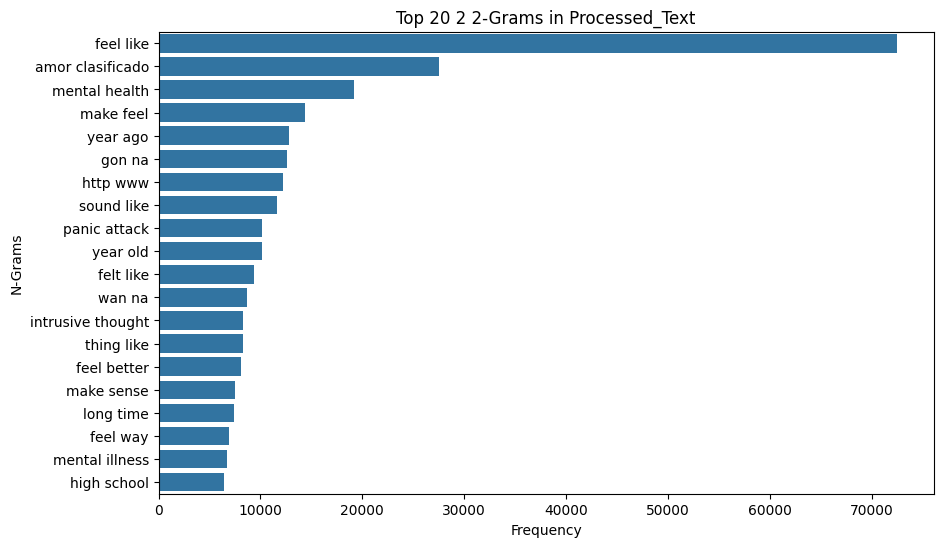

In [ ]:

# Perform bigram analysis on the processed 'Text' column
plot_ngrams(data, ngram_range=(2, 2), top_n=20, column='Processed_Text')



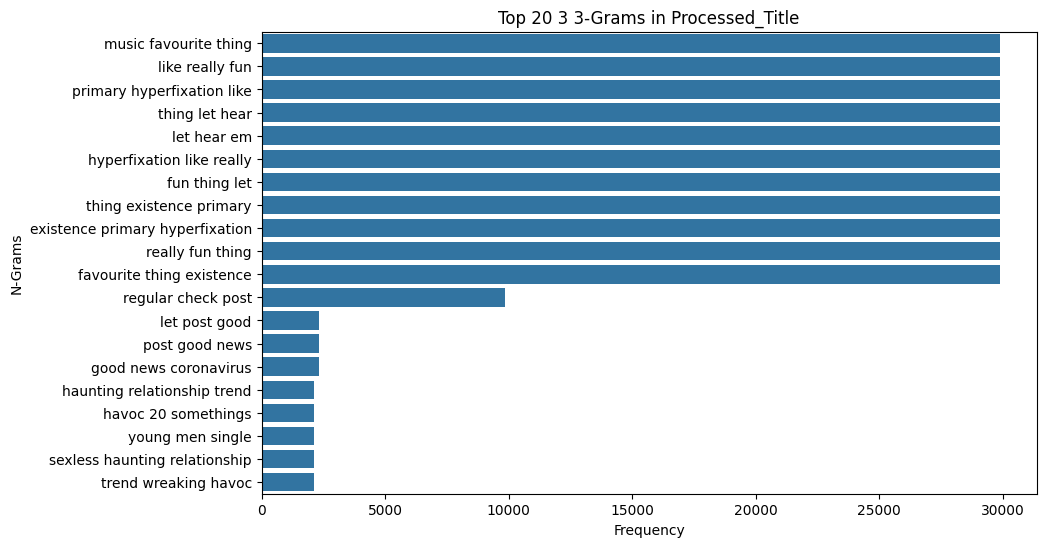

In [ ]:
# Perform trigram analysis on the processed 'Title' column
plot_ngrams(data, ngram_range=(3, 3), top_n=20, column='Processed_Title')

In [ ]:
# HTML content
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    body {font-family: Arial, sans-serif; }
    h2 { color: green;}
    p { font-size: 18px; }
    strong { color: #2980b9;}
  </style>
</head>
<body>
<h2>Distribution of Title Word Count:</h2>
<p>Most titles have a word count ranging between 0 and 20 words.
There is a peak around the 10-word count mark, which indicates that most titles are relatively concise.
A gradual decline in frequency is observed as the word count increases, with very few titles having more than 30 words.<p>

<h2>Distribution of Text Word Count: </h2>
<p>
The prevalence of bigrams like "feel like," "make feel," and "felt like" suggests a significant focus on expressing emotions, personal experiences, and introspective thoughts in the posts. This aligns with the nature of mental health subreddits, where individuals seek to share and reflect on their feelings.
</p>
<p>
The frequent occurrence of "mental health," "panic attack," and "intrusive thought" shows that mental health discussions are central to the dataset. These phrases may indicate that anxiety and intrusive thoughts are key topics of interest.
</p>
<p>
The trigrams in titles suggest that some titles might not be very descriptive or contain repetitive phrases. The presence of filler-like phrases, such as "like really fun" or "thing let hear," could imply some titles lack clarity or substance.
On the other hand, some trigrams point to specific topics, such as "good news coronavirus," which reflects discussions related to current events or updates.
Community Conversations:
</p>
<p>
The presence of phrases like "regular check post" might indicate a community-oriented behavior, where users regularly update or contribute certain types of posts, possibly related to progress, health updates, or weekly threads.</p>
</body>
</html>
"""

# Display the HTML content
display(HTML(html_content))





In [ ]:
data.head()

,index,Timestamp,Subreddit,Type,Post_id,Title,Author,Text,Score,Total_comments,month,hour,day_of_week,Sentiment,Title_word_count,Text_word_count,Category,Processed_Title,Processed_Text
0,0,2018-05-28 19:41:32,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Candle1nTh3Dark,"Thank you for posting this, I've failed univer...",141.0,0.0,5,19,Monday,negative,48,20,MH_Improvement,mental health awareness month schizoaffective ...,thank posting failed university 3 time due hos...
1,1,2018-05-28 19:53:47,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,sciencelove1994,I have schizoaffective mixed episode type. I a...,61.0,0.0,5,19,Monday,positive,48,33,MH_Improvement,mental health awareness month schizoaffective ...,schizoaffective mixed episode type junior ivy ...
2,2,2018-05-28 20:04:29,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Unknown,As someone who is struggling with mental illne...,36.0,0.0,5,20,Monday,negative,48,49,MH_Improvement,mental health awareness month schizoaffective ...,someone struggling mental illness currently co...
3,3,2018-05-28 20:00:07,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,swild89,I’m heading back now at 28! Thanks for the ins...,28.0,0.0,5,20,Monday,positive,48,11,MH_Improvement,mental health awareness month schizoaffective ...,heading back 28 thanks inspiration
4,4,2018-05-28 21:21:11,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,BoozeMeUpScotty,Yayyyy!!! Good for you! This is my favorite ki...,11.0,0.0,5,21,Monday,positive,48,499,MH_Improvement,mental health awareness month schizoaffective ...,yayyyy good favorite kind post see anywhere wo...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838721 entries, 0 to 838720
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             838721 non-null  int64         
 1   Timestamp         838721 non-null  datetime64[ns]
 2   Subreddit         838721 non-null  object        
 3   Type              838721 non-null  object        
 4   Post_id           838721 non-null  object        
 5   Title             838721 non-null  object        
 6   Author            838721 non-null  object        
 7   Text              838721 non-null  object        
 8   Score             838721 non-null  float64       
 9   Total_comments    838721 non-null  float64       
 10  month             838721 non-null  int32         
 11  hour              838721 non-null  int32         
 12  day_of_week       838721 non-null  object        
 13  Sentiment         838721 non-null  object        
 14  Titl

In [ ]:

# Removing URLs from both title and text columns
data['Processed_Text'] = data['Processed_Text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
data['Processed_Title'] = data['Processed_Title'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
# Removing the '#' symbol from hashtags but keeping the words
data['Processed_Text'] = data['Processed_Text'].apply(lambda x: re.sub(r'#', '', x))
data['Processed_Title'] = data['Processed_Title'].apply(lambda x: re.sub(r'#', '', x))


In [ ]:
# Define the path where you want to save the CSV file
csv_file_path = '/content/drive/MyDrive/Relevant_health_data.csv'

# Save the DataFrame as CSV
data.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

Data saved to /content/drive/MyDrive/Relevant_health_data.csv


In [ ]:
data.head()

,index,Timestamp,Subreddit,Type,Post_id,Title,Author,Text,Score,Total_comments,month,hour,day_of_week,Sentiment,Title_word_count,Text_word_count,Category,Processed_Title,Processed_Text
0,0,2018-05-28 19:41:32,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Candle1nTh3Dark,"Thank you for posting this, I've failed univer...",141.0,0.0,5,19,Monday,negative,48,20,MH_Improvement,mental health awareness month schizoaffective ...,thank posting failed university 3 time due hos...
1,1,2018-05-28 19:53:47,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,sciencelove1994,I have schizoaffective mixed episode type. I a...,61.0,0.0,5,19,Monday,positive,48,33,MH_Improvement,mental health awareness month schizoaffective ...,schizoaffective mixed episode type junior ivy ...
2,2,2018-05-28 20:04:29,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,Unknown,As someone who is struggling with mental illne...,36.0,0.0,5,20,Monday,negative,48,49,MH_Improvement,mental health awareness month schizoaffective ...,someone struggling mental illness currently co...
3,3,2018-05-28 20:00:07,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,swild89,I’m heading back now at 28! Thanks for the ins...,28.0,0.0,5,20,Monday,positive,48,11,MH_Improvement,mental health awareness month schizoaffective ...,heading back 28 thanks inspiration
4,4,2018-05-28 21:21:11,mentalhealth,Comment,8msp9v,Mental Health Awareness Month: I have schizoaf...,BoozeMeUpScotty,Yayyyy!!! Good for you! This is my favorite ki...,11.0,0.0,5,21,Monday,positive,48,499,MH_Improvement,mental health awareness month schizoaffective ...,yayyyy good favorite kind post see anywhere wo...
